In [ ]:
import os
import re
#import matplotlib as mpl
#import matplotlib.pyplot as plt
#import mpl_toolkits.basemap.pyproj as pyproj
import numpy as np
#from mpl_toolkits.basemap import Basemap
#from pyhdf.SD import *
#import xarray as xr
#import rioxarray as rxr
#import cv2
import pandas
import MisrToolkit as mtk
class MISR_geo_data:
    def __init__(self,file):
        self.misr_file = mtk.MtkFile(file)
    
    def get_date(self):
        m =  self.misr_file # ,mask_and_scale=True)
        times = m.block_metadata_field_read('PerBlockMetadataTime','BlockCenterTime')
        a = [ t for t in times if t is not '' ]
        date = a[1]
        date = pandas.to_datetime(date).date()
        self.date = str(date)
        #m.core_metadata_get (EQUATORCROSSINGTIME)
        return str(date)
    def get_path(self):
        m =  self.misr_file 
        path = m.attr_get('Path_number')
        return path
    
    def get_orbit(self):
        m =  self.misr_file 
        orbit = m.core_metadata_get('ORBITNUMBER')
        return orbit

    def check_if_pm_station_is_in_misr_image(self,pm_lat,pm_lon):
        m = self.misr_file
        path = m.attr_get('Path_number')
        start_block = int(m.attr_get('Start_block'))
        end_block = int(m.attr_get('End block'))
        blocks = np.arange(start_block,end_block,dtype='int')
        #r = mtk.MtkRegion(path,start_block,end_block)
        mgrid =  m.grid('BlueBand')
        res = mgrid.attr_get('Block_size.resolution_x')
        #map_info = r.snap_to_grid(path, res)
        #lat,lon = map_info.create_latlon()
        try:
            mtk.latlon_to_bls(path,res,pm_lat, pm_lon)
        except:
            return False
        
        return True

In [ ]:
misr_file = '/home/adiraz/adiraz/misr_data/MISR_AM1_GRP_TERRAIN_GM_P042_O116011_DA_F03_0024.hdf'
m = mtk.MtkFile(misr_file)
# path = m.attr_get('Path_number')
# start_block = int(m.attr_get('Start_block'))
# end_block = int(m.attr_get('End block'))
# blocks = np.arange(start_block,end_block,dtype='int')z
# r = mtk.MtkRegion(path,start_block,end_block)
# mgrid =  m.grid('BlueBand')
# res = mgrid.attr_get('Block_size.resolution_x')
# map_info = r.snap_to_grid(path, res)

# somx,somy =mtk.latlon_to_somxy(path, -200.0,-200.0)
# mtk.somxy_to_bls(path,res,somx,somy)
# #map_info.latlon_to_ls(-200.0,-200.0)

# # m = MISR_geo_data(misr_file)
# # m.check_if_station_is_in_image(10,10)

In [ ]:
m.block_metadata_list
m.block_metadata_field_list('PerBlockMetadataTime')
m.block_metadata_field_read('PerBlockMetadataTime', 'BlockCenterTime')[63]

In [ ]:
# mtk.bls_to_latlon(path,res,63,200,200)
# # mtk.latlon_to_bls(path,res,36.448, -117.643)

In [ ]:
import json
import numpy as np
#import xarray as xr
#import rioxarray as rxr
#import MISR_geo_data
import os
import pandas


def find_matches_between_pm_to_misr_data(pm_data_file,misr_dir):
    matches_misr_pm_data = []

    pd = PM_Data(pm_data_file)
    pm_data = pd.load()
    misr_subset_dir = misr_dir
    misr_files = [os.path.join(misr_subset_dir,f) for f in os.listdir(misr_subset_dir) if f.endswith('hdf')]
    misr_files_per_date = {}
    for file in misr_files:
        #print('reading file ', file)
        misr = MISR_geo_data(file)
        misr_date = misr.get_date()
        if misr_date not in misr_files_per_date.keys():
            misr_files_per_date[misr_date]  = []
        misr_files_per_date[misr_date].append({'file_name':  file ,
                                               #'blocks_geo_locations' : misr.get_max_min_lon_lat_per_block(),
                                               'orbit': misr.get_orbit()})

    pm_data_per_date = {}
    for pm_measure in pm_data:
        pm_date = pm_measure['date_local']
        if pm_date not in pm_data_per_date:
            pm_data_per_date[pm_date] =[]
        pm_data_per_date[pm_date].append(pm_measure)
    print("completed dates matching")
    #check date convention
    for date in pm_data_per_date.keys():
        for pm_station_data in pm_data_per_date[date]:
            pm_geo_location_lat = pm_station_data['latitude']
            pm_geo_location_lon = pm_station_data['longitude']
            if date in misr_files_per_date.keys():
                misr_data_from_this_date = misr_files_per_date[date]
                for misr_file in misr_data_from_this_date:
                    misr = MISR_geo_data(misr_file['file_name'])
                    #misr_blocks_geo_location = misr_file['blocks_geo_locations']
                    #for bidx, misr_geo_location in enumerate(misr_blocks_geo_location):
                    if misr.check_if_pm_station_is_in_misr_image(pm_geo_location_lat,pm_geo_location_lon):
                        matches_misr_pm_data.append({'pm_data': pm_station_data, 'image_data' : {'file' : misr_file}})
                        print('Found match!')

    return matches_misr_pm_data



In [ ]:
# pm_data_file = '/home/adiraz/adiraz/misr_data/la_pm_2021_all.json'
# misr_dir = '/home/adiraz/adiraz/misr_data'
# matches_misr_pm_data = find_matches_between_pm_to_misr_data(pm_data_file,misr_dir)
# matches_file = '/home/adiraz/adiraz/matches_pm_misr.json'
# with open(matches_file,'w') as f:
#     json.dump(matches_misr_pm_data,f)

In [ ]:
# matches_misr_pm_data

In [ ]:
# matches_misr_pm_data = []

# pd = PM_Data(pm_data_file)
# pm_data = pd.load()
# misr_subset_dir = misr_dir
# misr_files = [os.path.join(misr_subset_dir,f) for f in os.listdir(misr_subset_dir) if f.endswith('hdf')]
# misr_files_per_date = {}
# for file in misr_files:
#     #print('reading file ', file)
#     misr = MISR_geo_data(file)
#     misr_date = misr.get_date()
#     if misr_date not in misr_files_per_date.keys():
#         misr_files_per_date[misr_date]  = []
#     misr_files_per_date[misr_date].append({'file_name':  file ,
#                                            #'blocks_geo_locations' : misr.get_max_min_lon_lat_per_block(),
#                                            'orbit': misr.get_orbit()})

# pm_data_per_date = {}
# for pm_measure in pm_data:
#     pm_date = pm_measure['date_gmt']
#     if pm_date not in pm_data_per_date:
#         pm_data_per_date[pm_date] =[]
#     pm_data_per_date[pm_date].append(pm_measure)
# print("completed dates matching")
# #check date convention
# for date in pm_data_per_date.keys():
#     for pm_station_data in pm_data_per_date[date]:
#         pm_geo_location_lat = pm_station_data['latitude']
#         pm_geo_location_lon = pm_station_data['longitude']
#         if date in misr_files_per_date.keys():
#             misr_data_from_this_date = misr_files_per_date[date]
#             for misr_file in misr_data_from_this_date:
#                 misr = MISR_geo_data(misr_file['file_name'])
#                 #misr_blocks_geo_location = misr_file['blocks_geo_locations']
#                 #for bidx, misr_geo_location in enumerate(misr_blocks_geo_location):
#                 if misr.check_if_pm_station_is_in_misr_image(pm_geo_location_lat,pm_geo_location_lon):
#                     matches_misr_pm_data.append({'pm_data': pm_station_data, 'image_data' : {'file' : misr_file}})
#                     print('Found match!')


In [ ]:
# date= '2021-10-09'
# pm_data_this_date = pm_data_per_date[date]
# misr_files_per_date[date]

In [ ]:
# data = [ (pm_data['latitude'],pm_data['longitude']) for pm_data in pm_data_per_date[date]]

In [ ]:
# data

In [ ]:
# mtk.latlon_to_bls(42,res,34.669739, -118.130511)

In [ ]:
# for misr_file in misr_data_from_this_date:
#     misr = MISR_geo_data(misr_file['file_name'])
#     #misr_blocks_geo_location = misr_file['blocks_geo_locations']
#     #for bidx, misr_geo_location in enumerate(misr_blocks_geo_location):
#     if misr.check_if_pm_station_is_in_misr_image(pm_geo_location_lat,pm_geo_location_lon):
#         matches_misr_pm_data.append({'pm_data': pm_station_data, 'image_data' : {'file' : misr_file , 'block' : bidx}})
#         print('Found match!')


In [ ]:
pm_geo_location_lat

In [ ]:
pm_geo_location_lon

In [ ]:
ret = misr.check_if_pm_station_is_in_misr_image(pm_geo_location_lat,pm_geo_location_lon)

In [ ]:
pm_geo_location_lat,pm_geo_location_lon

In [1]:
misr_file = '/home/adiraz/adiraz/misr_data/202211176186/2011/MISR_AM1_GRP_TERRAIN_GM_P039_O058853_AF_F03_0024.b062-064.f9043c529.hdf'
import MisrToolkit as mtk

misr_file = mtk.MtkFile(misr_file)
g = misr_file.grid('BlueBand')
f = g.field('Blue Radiance')
#block_data = f.read(block, bl|ock)






In [2]:
a = f.read(63,63)

In [3]:
from PIL import Image

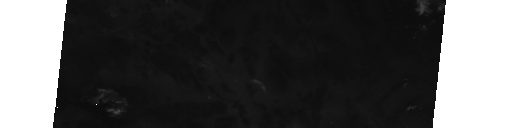

In [8]:
Image.fromarray(a[0])

0.047203224152326584

In [126]:
GRID_LIST = ['BlueBand',
 'GreenBand',
 'RedBand',
 'NIRBand']

FIELDS_LIST = ['Blue Radiance','Green Radiance','Red Radiance', 'NIR Radiance']
import matplotlib.pyplot as plt
import numpy as np 
g = misr_file.grid('BlueBand')
scale_factor = g.attr_get('Scale factor')
f = g.field('Blue Radiance/RDQI')
c = f.read(63,63)
fva = f.fill_value
_FillValue = fva
datas = np.right_shift(c,2)

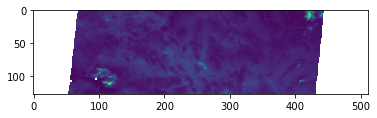

In [127]:
#datas = np.right_shift(c,2)
dataf = datas.astype(np.double)
dataf[datas == _FillValue] = np.nan
dataf[ datas > 16376] = np.nan
#if dataf.shape[0] > self.work_resolution[0]:
#    image_scale = 0.25
#    dataf = cv2.imresize(dataf,(0,0),fx = image_scale,fy=image_scale, interpolation = cv2.INTER_CUBIC)
datam = np.ma.masked_array(dataf,mask= np.isnan(dataf))
datam = scale_factor * datam
plt.imshow(datam[0])

In [100]:
f2 = g.field('Blue RDQI')


In [89]:
np.binary_repr(int(datam[0,1,127]))

'100000111'

In [99]:
g.field_list

['Blue Radiance/RDQI',
 'Latitude',
 'Longitude',
 'Blue Radiance',
 'Blue RDQI',
 'Blue DN',
 'Blue Equivalent Reflectance',
 'Blue Brf']

In [102]:
f2.read()

TypeError: function takes at least 1 argument (0 given)